### The correlates of crackling

In [1]:
import sys

sys.path.insert(1, "/home/vinicius/storage1/projects/GrayData-Analysis")

In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import scipy.stats as stats
import seaborn as sns
import xarray as xr
from frites.conn.conn_tf import _tf_decomp
from frites.stats import confidence_interval
from frites.utils import parallel_func
from mne.filter import filter_data
from mne.stats import fdr_correction
from tqdm import tqdm

from config import get_dates, return_delay_split, return_evt_dt
from GDa.loader import loader
from GDa.session import session
from GDa.stats.bursting import find_start_end

In [3]:
def hilbert_spectra(
    data, fsample, freqs, bandwidth, n_jobs=1, verbose=False, kw_filter={}
):
    """
    Compute the Hilbert spectra of a 3D data array.

    Parameters:
    - data (xr.DataArray): Input data array with dimensions ("trials", "roi", "time").
    - fsample (float): Sampling frequency of the data.
    - freqs (array-like): Center frequencies for the spectral analysis.
    - bandwidth (float): Half-width of the frequency bands.
    - n_jobs (int, optional): Number of parallel jobs to run for filtering. Default is 1.
    - verbose (bool, optional): If True, print verbose messages during filtering. Default is False.
    - kw_filter (dict, optional): Additional keyword arguments for the `filter_data` function.

    Returns:
    - xr.DataArray: Hilbert spectra of the input data, with dimensions ("trials", "roi", "freqs", "times").

    Note:
    The input data is filtered into frequency bands centered at the specified frequencies with the given bandwidth.
    The Hilbert transform is then applied to obtain the analytic signal, and the squared magnitude of the analytic
    signal is computed to obtain the Hilbert spectra.

    The resulting DataArray has dimensions representing trials, regions of interest (ROIs), frequency bins, and time points.
    """

    from mne.filter import filter_data

    assert isinstance(data, xr.DataArray)

    dims = data.dims
    coords = data.coords
    attrs = data.attrs

    np.testing.assert_array_equal(dims, ("trials", "roi", "time"))

    lfreqs = np.clip(freqs - bandwidth, 0, np.inf)
    hfreqs = freqs + bandwidth

    bands = np.stack((lfreqs, hfreqs), axis=1)

    data_filtered = []
    for lf, hf in bands:
        data_filtered += [
            filter_data(
                data.values,
                fsample,
                lf,
                hf,
                n_jobs=n_jobs,
                **kw_filter,
                verbose=verbose
            )
        ]
    data_filtered = np.stack(data_filtered, axis=1)
    hilbert = scipy.signal.hilbert(data_filtered, axis=-1)
    sxx = hilbert * np.conj(hilbert)

    sxx = xr.DataArray(
        sxx.real,
        dims=("trials", "freqs", "roi", "times"),
        coords=(coords["trials"], freqs, coords["roi"], coords["time"]),
    ).transpose("trials", "roi", "freqs", "times")

    sxx.attrs = attrs

    return sxx

#### Setting configurations

In [4]:
_ROOT = os.path.expanduser("~/funcog/gda/")
metric = "coh"
monkey = "lucy"

In [5]:
sessions = get_dates(monkey)

In [6]:
evt_dt = return_evt_dt("cue", monkey)
stages = [[-0.5, -0.2], [0, 0.4], [0.5, 0.9], [0.9, 1.3], [1.1, 1.5]]
stage_labels = ["P", "S", "D1", "D2", "Dm"]

In [7]:
data_loader = loader(_ROOT=_ROOT)

#### Loading LFP, unities and power

In [125]:
# Window in which the data will be read
evt_dt = return_evt_dt("cue", monkey=monkey)
# Path to LFP data
raw_path = os.path.expanduser("~/funcog/gda/GrayLab/")
# Instantiate class
ses = session(
    raw_path=raw_path,
    monkey=monkey,
    date="141017",
    session=1,
    slvr_msmod=True,
    align_to="cue",
    evt_dt=evt_dt,
)

# Read LFP
ses.read_from_mat()
LFP = ses.filter_trials(trial_type=[1], behavioral_response=[1])

roi_channel = [f"{r} ({c})" for r, c in zip(LFP.roi.data, LFP.attrs["channels_labels"])]
LFP = LFP.assign_coords({"roi": roi_channel})

# Read SPIKES
ses.read_from_mat(load_spike_times=True)
SPIKES = ses.spike_times.sel(trials=LFP.trials)

(595, 94, 3650)


In [126]:
SPIKES = SPIKES.assign_coords({"roi": roi_channel})

In [127]:
kw_loader = dict(
    session="141017",
    aligned_at="cue",
    channel_numbers=True,
    monkey=monkey,
    decim=5,
    mode="hilbert",
)

POWER = data_loader.load_power(**kw_loader, trial_type=1, behavioral_response=1)

ZPOWER = (POWER - POWER.mean("times")) / POWER.std("times")

In [128]:
kw_loader = dict(
    session="141017",
    aligned_at="cue",
    channel_numbers=True,
    monkey=monkey,
    decim=5,
    mode="morlet",
)

POWER2 = data_loader.load_power(**kw_loader, trial_type=1, behavioral_response=1)

ZPOWER2 = (POWER - POWER.mean("times")) / POWER.std("times")

In [129]:
CRACKLES = ZPOWER >= 3

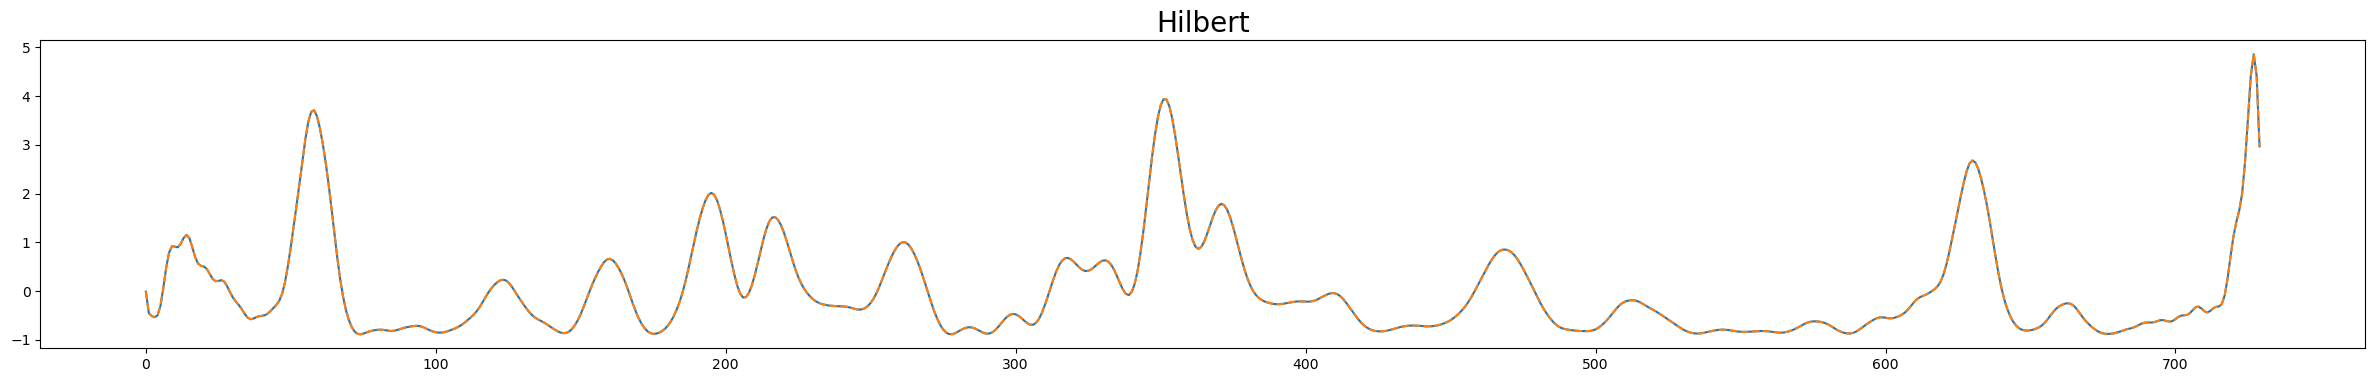

In [130]:
plt.figure(figsize=(30, 4))
plt.plot(ZPOWER.sel(roi="a3 (106)", freqs=27)[10])
plt.plot(ZPOWER2.sel(roi="a3 (106)", freqs=27)[10], "--")
plt.title("Hilbert", fontsize=20)
plt.savefig("test.png")

In [138]:
LFP_FILTERED.roi

<xarray.DataArray 'roi' (roi: 94)>
array(['a46D (1)', 'a8B (4)', 'F6 (8)', 'a9/46D (9)', 'a8M (10)', 'a8B (11)',
       'a8B (12)', 'F7 (13)', 'F7 (14)', 'a8r (15)', 'a8M (16)', 'a8M (17)',
       'a8B (18)', 'F7 (19)', 'F7 (20)', 'a8L (21)', 'a8r (22)', 'a8M (23)',
       'a8M (24)', 'F2 (28)', 'a44 (29)', 'F2 (34)', 'F2 (36)', 'a8L (38)',
       'a8L (39)', 'a8L (40)', 'F2 (43)', 'F2 (44)', 'F2 (45)', 'F2 (54)',
       'F1 (59)', 'F1 (63)', 'a3 (64)', 'a3 (65)', 'F1 (69)', 'F1 (73)',
       'F1 (83)', 'F1 (84)', 'a2 (86)', 'F1 (92)', 'F1 (95)', 'a1 (101)',
       'a1 (103)', 'F1 (104)', 'F1 (105)', 'a3 (106)', 'a7B (110)',
       'AIP (111)', 'a2 (112)', 'a1 (114)', 'a1 (115)', 'a1 (116)', 'a3 (117)',
       'a7B (121)', 'a7B (122)', 'a5 (124)', 'a2 (125)', 'a2 (126)',
       'a1 (127)', 'a5 (136)', 'a2 (138)', 'TPt (141)', 'a5 (149)',
       'a7A (156)', 'a5 (161)', 'V4t (163)', 'DP (168)', 'a5 (172)',
       'MT (175)', 'DP (177)', 'a7A (181)', 'V6A (183)', 'DP (191)',
       'PIP (193)', 'DP (201)', 'V2 (203)', 'V2 (204)', 'V6A (205)',
       'V1 (206)', 'V1 (212)', 'V2 (214)', 'V2 (215)', 'V1 (219)', 'V2 (222)',
       'V2 (224)', 'V1 (232)', 'V1 (233)', 'V1 (241)', 'V1 (242)', 'V1 (245)',
       'V1 (247)', 'V1 (248)', 'V1 (250)', 'V1 (251)'], dtype='<U10')
Coordinates:
  * roi      (roi) <U10 'a46D (1)' 'a8B (4)' 'F6 (8)' ... 'V1 (250)' 'V1 (251)'

In [132]:
LFP_FILTERED = filter_data(LFP.data, 1000, 25, 40)
LFP_FILTERED = xr.DataArray(LFP_FILTERED, dims=LFP.dims, coords=LFP.coords)

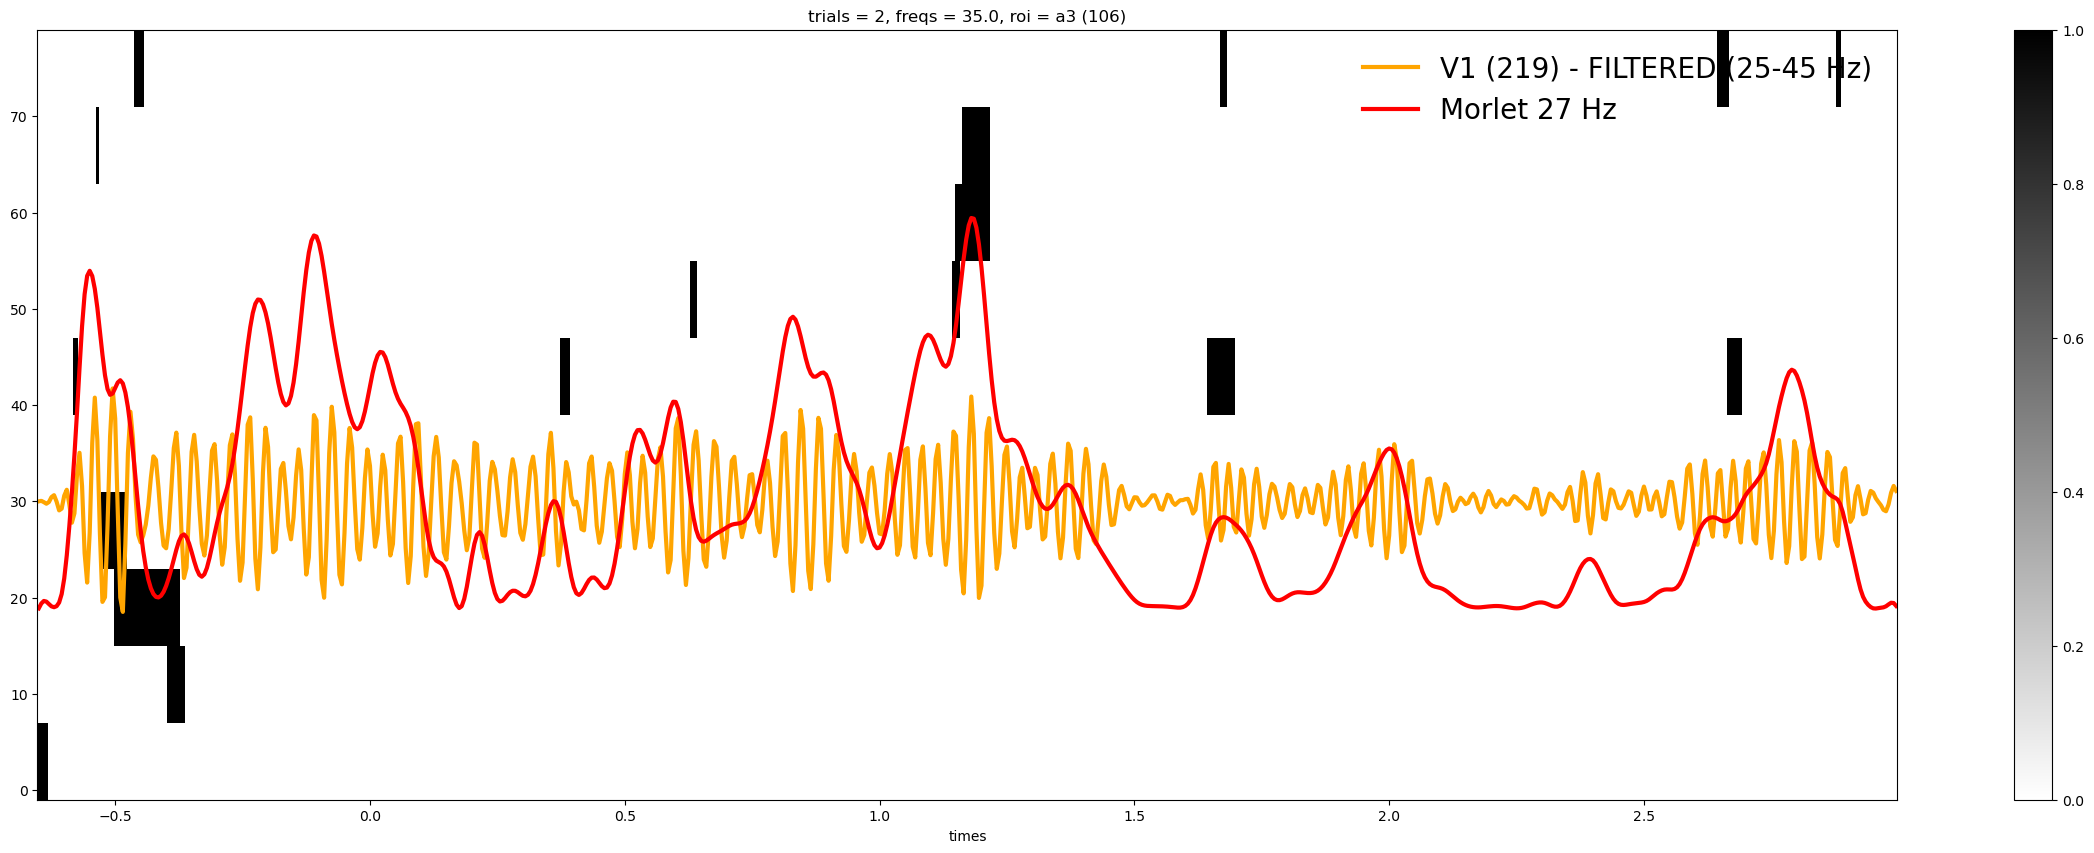

In [156]:
plt.figure(figsize=(30, 10))
CRACKLES.sel(roi="a3 (106)").isel(trials=0).plot(cmap="binary")
((LFP_FILTERED.sel(roi="a3 (106)")[0][..., ::5] * 5e4 + 30)).plot(lw=3, c="orange", label="V1 (219) - FILTERED (25-45 Hz)")
((ZPOWER2.sel(roi="a3 (106)", freqs=35)[0] * 10 + 30)).plot(lw=3, c="r", label="Morlet 27 Hz")
plt.legend(fontsize=20, frameon=False)
plt.savefig("superimposed.pdf")

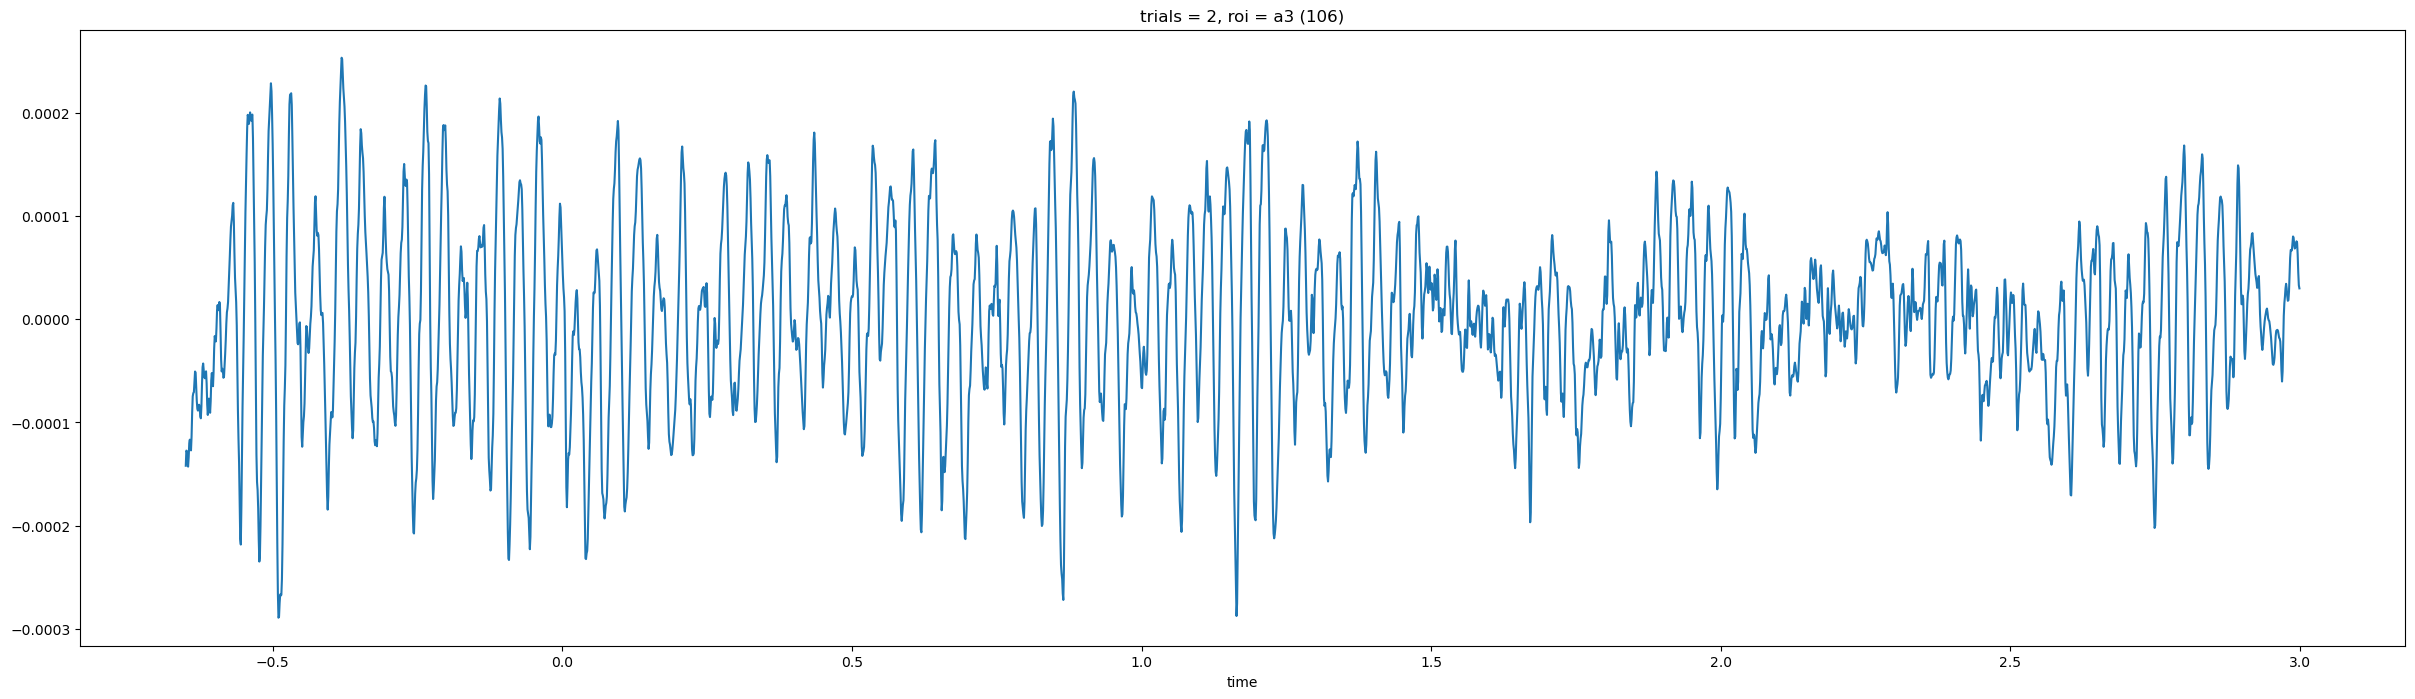

In [153]:
plt.figure(figsize=(30, 8))
LFP.sel(roi="a3 (106)")[0].plot()

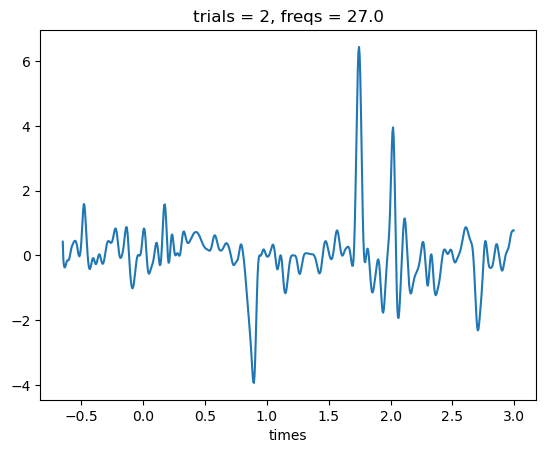

In [188]:
x = ZPOWER.isel(roi=0, trials=0, freqs=3) 
y = ZPOWER.isel(roi=30, trials=0, freqs=3)

(x * y).plot()


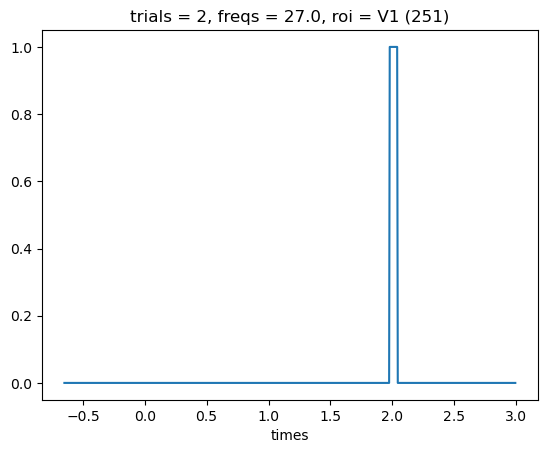

In [181]:
( y >= 3 ).plot()

In [71]:
def triggered_avg(
    data=None,
    spikes=None,
    low_pass=None,
    high_pass=None,
    win_size=None,
    verbose=False,
    decim=None,
):

    n_trials, n_roi, n_times = data.shape
    roi = data.roi.data

    # High-pass filtered data
    data_hp = filter_data(
        data.data, data.fsample, l_freq=low_pass, h_freq=high_pass, verbose=verbose
    )
    # Converts back to DataArray
    data_hp = xr.DataArray(data_hp, dims=data.dims, coords=data.coords)
    """
    data_hp = (data_hp - data_hp.mean(("trials", "time"))) / data_hp.std(
        ("trials", "time")
    )
    """

    if isinstance(decim, int):
        data_hp = data_hp[..., ::decim]
        n_times = data_hp.sizes["time"]

    # win_size = int(win_size * data.fsample)

    data_hp = data_hp.data.swapaxes(0, 1).reshape(n_roi, n_trials * n_times)
    spikes = spikes.data.reshape(n_roi, n_trials * n_times)

    def _for_roi(i):
        peaks = find_start_end(spikes[i]).mean(1).astype(int)
        snipets = np.zeros((len(peaks), 2 * win_size))
        for pidx, idx in enumerate(peaks):
            temp = data_hp[i, (idx - win_size) : (idx + win_size)]
            if len(temp) == 2 * win_size:
                snipets[pidx, :] = temp
        return (
            confidence_interval(snipets, axis=0, verbose=False).squeeze().T
        )  # snipets.mean(0)

    snipets = np.stack([_for_roi(i) for i in range(n_roi)])
    print(snipets.shape)
    times = np.linspace(-win_size, win_size, snipets.shape[1])
    snipets = xr.DataArray(
        snipets,
        dims=("roi", "times", "bounds"),
        coords=(
            roi,
            times,
            ["lower", "higher"],
        ),
    )

    return snipets

In [115]:
def shuffle_along_axis(a, axis):
    idx = np.random.rand(*a.shape).argsort(axis=axis)
    return np.take_along_axis(a, idx, axis=axis)

In [124]:
y = LFP 

CTA = []
nCTA = []

for freq in [27]:

    x = CRACKLES.sel(freqs=freq)

    out = triggered_avg(
        data=SPIKES_CV,
        spikes=x,
        low_pass=1,
        high_pass=250,
        win_size=20,
        decim=5,
        verbose=False,
    )

    x_SHUFFLE = x.copy()
    x_SHUFFLE.values = shuffle_along_axis(x.data, 1)
    
    out1 = triggered_avg(
        data=SPIKES_CV,
        spikes=x_SHUFFLE,
        low_pass=1,
        high_pass=250,
        win_size=20,
        decim=5,
        verbose=False,
    )
    
    CTA += [out]
    nCTA += [out1]

(94, 40, 2)
(94, 40, 2)


In [118]:
CTA = xr.concat(CTA, "freqs").assign_coords({"freqs": [27]})
nCTA = xr.concat(nCTA, "freqs").assign_coords({"freqs": [27]})

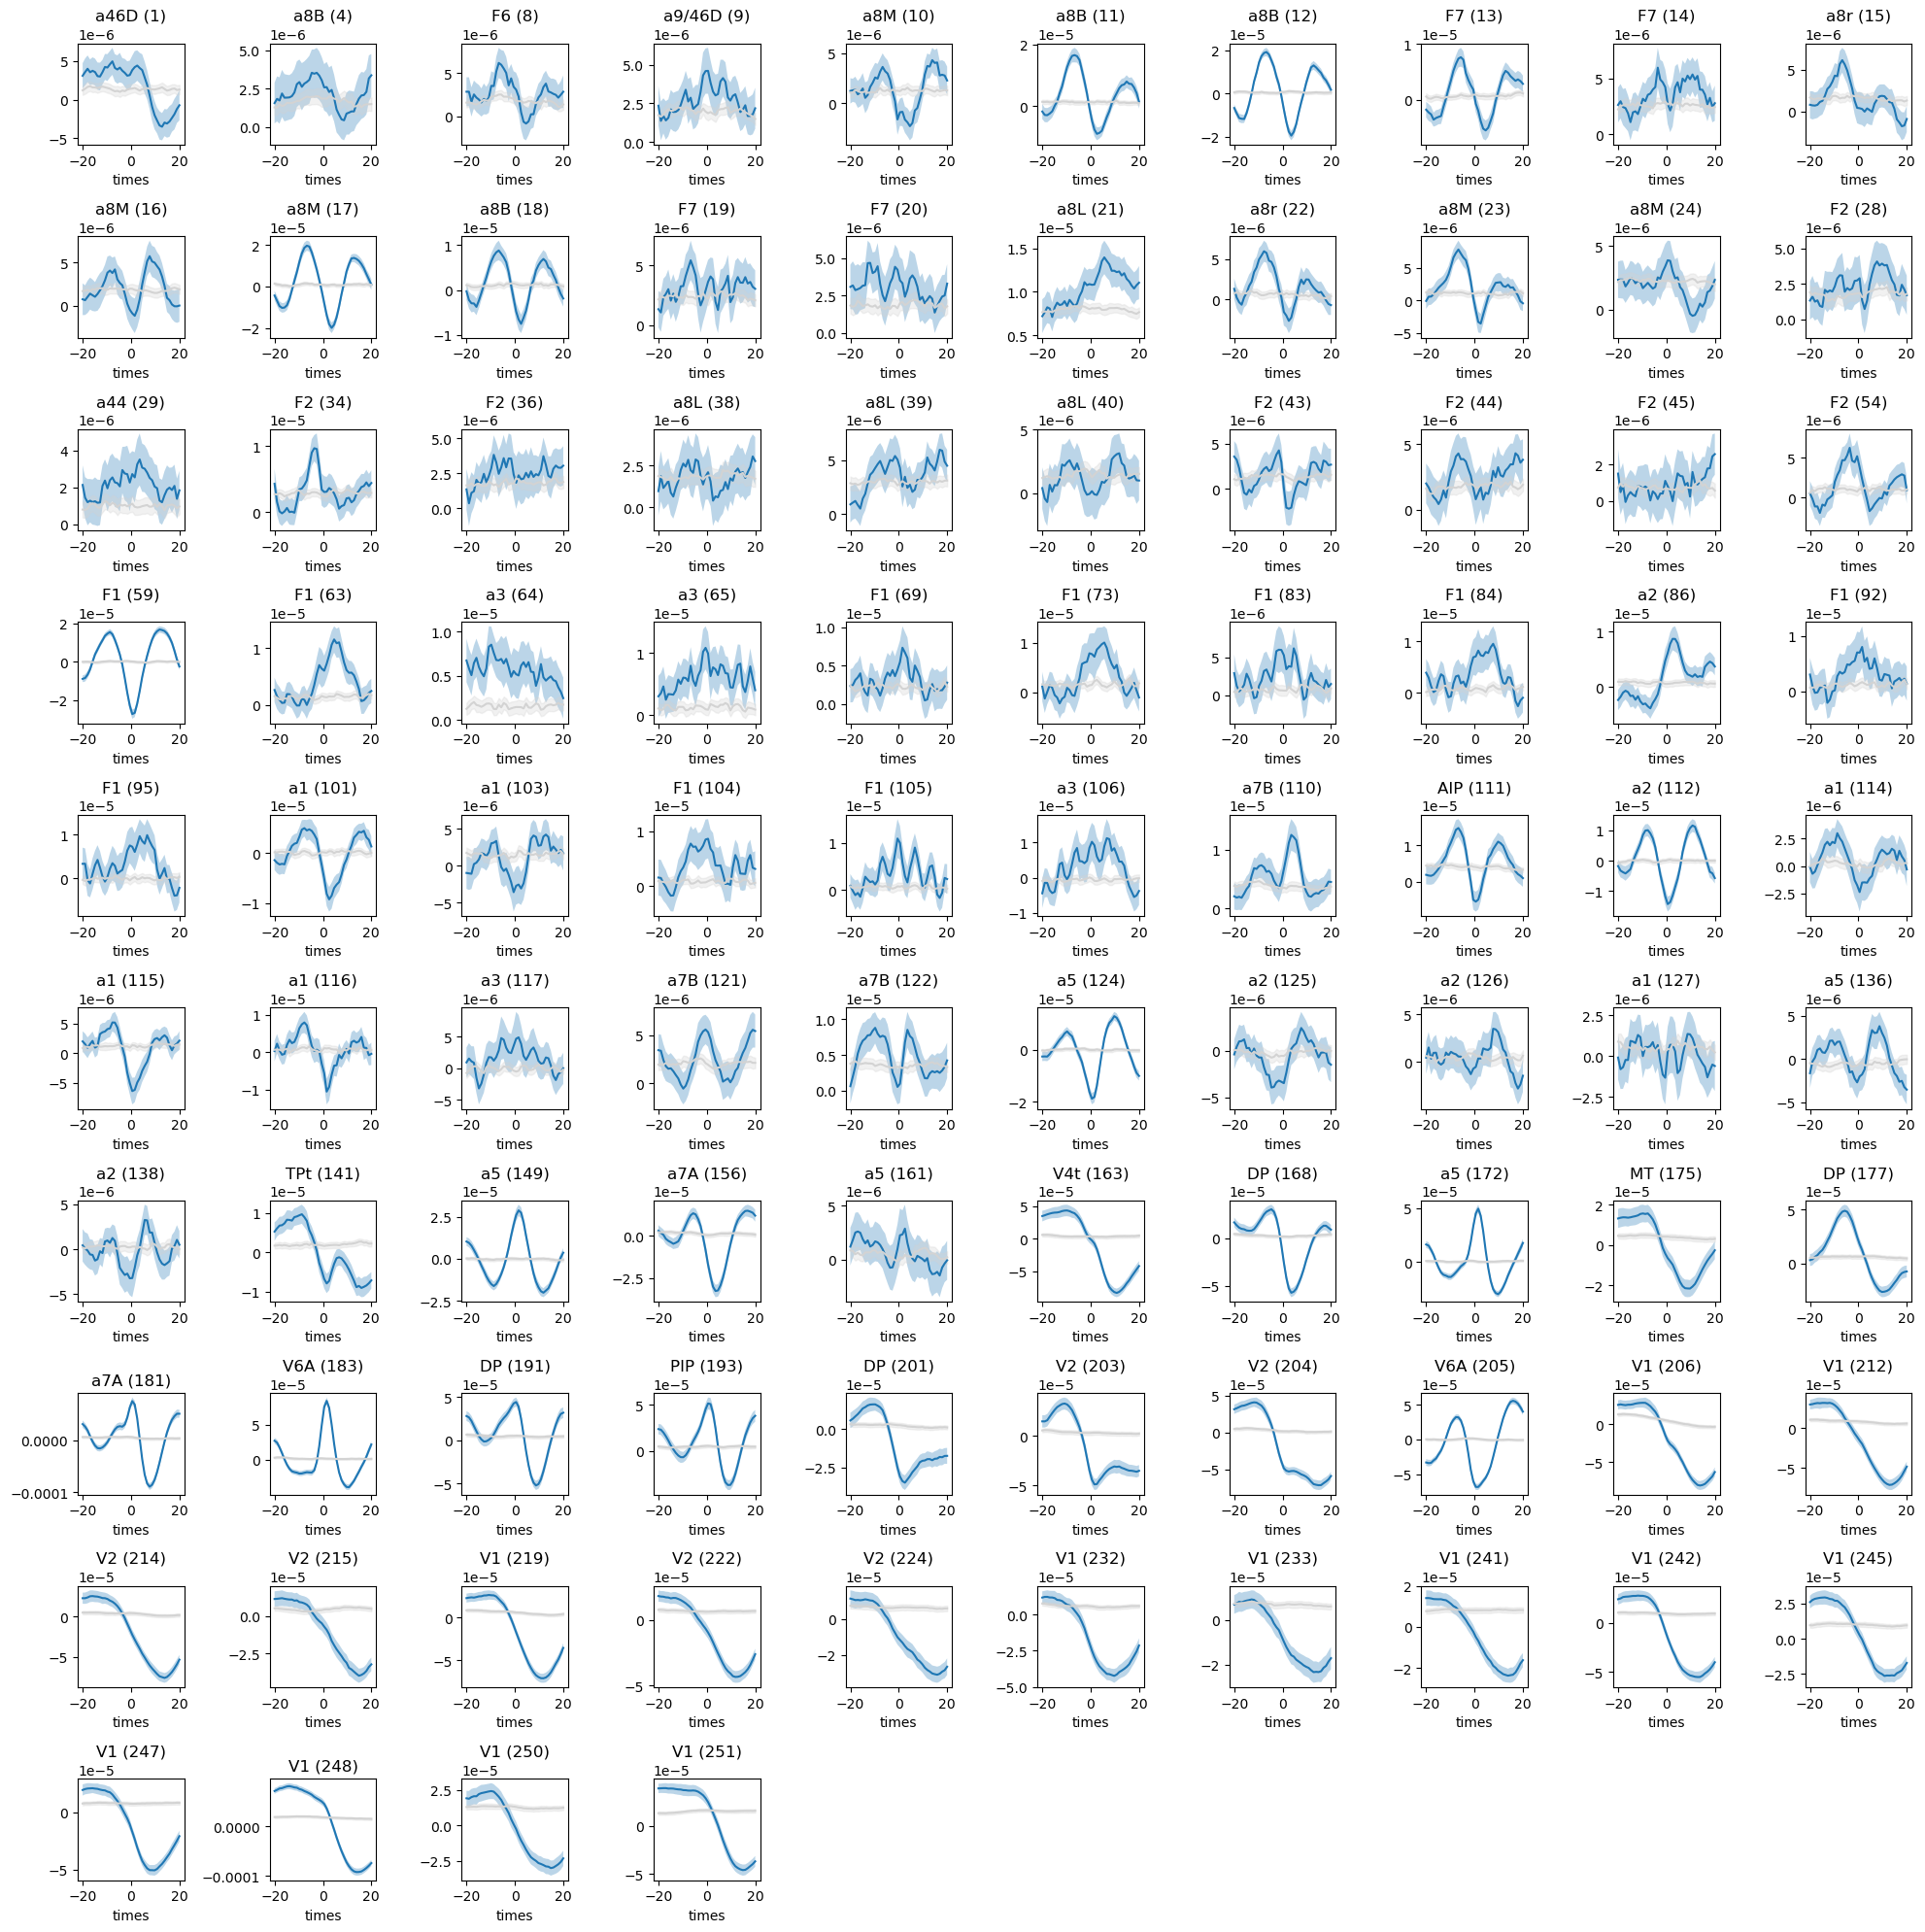

In [122]:
plt.figure(figsize=(20, 20))
unique_rois = np.unique(out.roi.data)
for pos, r in enumerate(out.roi[:100].data):
    plt.subplot(10, 10, pos + 1)
    # Original
    CTA.sel(roi=r, freqs=27).median("bounds").plot()
    plt.fill_between(
        CTA.times,
        CTA.sel(roi=r, freqs=27, bounds="lower"),
        CTA.sel(roi=r, freqs=27, bounds="higher"),
        alpha=0.3,
    )
    # Surrogate
    nCTA.sel(roi=r, freqs=27).median("bounds").plot(c="lightgray")
    plt.fill_between(
        nCTA.times,
        nCTA.sel(roi=r, freqs=27, bounds="lower"),
        nCTA.sel(roi=r, freqs=27, bounds="higher"),
        alpha=0.3,
        color="lightgray"
    )
    plt.title(r)
plt.tight_layout()
plt.savefig("crackle_triggered_average.png")

In [80]:
kernel = np.hanning(100)

In [81]:
SPIKES_CV = scipy.signal.fftconvolve(SPIKES, kernel[None, None, :], axes=2, mode="same")

In [82]:
SPIKES_CV = xr.DataArray(SPIKES_CV, dims=SPIKES.dims, coords=SPIKES.coords)

In [86]:
SPIKES_CV.attrs["fsample"] = 1000